In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
stock_symbol = "MRF.NS"  
start_date = "2013-07-05"
end_date = "2023-07-05"
data = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
#Calculating MACD Indicator
data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA12'] - data['EMA26']
data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

In [4]:
#Identify Bull Flag Pattern
data['FlagHigh'] = data['High'].rolling(window=5).max()
data['FlagLow'] = data['Low'].rolling(window=5).min()
data['Flag'] = np.where(
    (data['FlagHigh'].shift(-5) > data['FlagHigh']) & (data['FlagLow'].shift(-5) > data['FlagLow']),
    1, 0
)

In [5]:
data['Position'] = np.where(
    (data['MACD'] > data['Signal']) & (data['Flag'] == 1),
    1,
    np.where((data['MACD'] < data['Signal']) & (data['Flag'] == 0),
             -1,
             0)
)

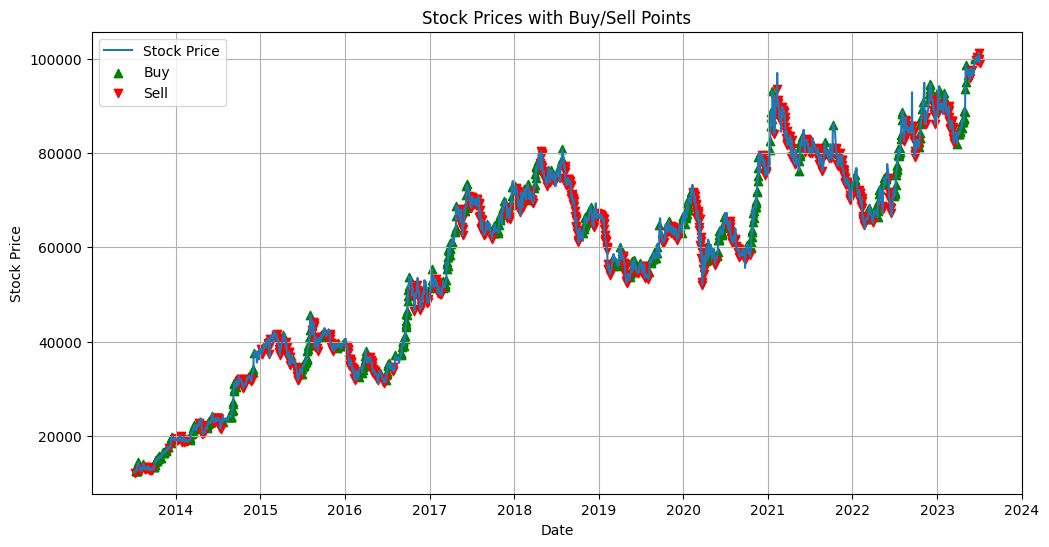

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Stock Price')
plt.scatter(data[data['Position'] == 1].index, data[data['Position'] == 1]['Close'], color='green', marker='^', label='Buy')
plt.scatter(data[data['Position'] == -1].index, data[data['Position'] == -1]['Close'], color='red', marker='v', label='Sell')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Prices with Buy/Sell Points')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
data['Returns'] = data['Close'].pct_change()
data['CumulativeReturns'] = (1 + data['Returns']).cumprod()
print(f"Cumulative Returns: {data['CumulativeReturns'].iloc[-1]}")

Cumulative Returns: 8.080627619448503


In [8]:
rolling_max = data['CumulativeReturns'].rolling(window=len(data), min_periods=1).max()
daily_drawdown = data['CumulativeReturns'] / rolling_max - 1
max_drawdown = (daily_drawdown.min())*100
print(f"Maximum Drawdown: {max_drawdown}")

Maximum Drawdown: -35.72847048029707


In [9]:
risk_free_rate = 0.04 #Assuming 4 percent risk free rate
cumulative_returns = data['CumulativeReturns']
daily_excess_returns = (cumulative_returns.pct_change() - risk_free_rate / 252)
sharpe_ratio = np.sqrt(252) * (daily_excess_returns.mean() / daily_excess_returns.std())
print(f"Sharpe Ratio: {sharpe_ratio}")

Sharpe Ratio: 0.7630508771342167
